# Leak-proof Aggregated Safety Model

This notebook trains a leak-proof aggregated model that predicts **area-level severity** and converts it to a **safety score (0–10)**. Train on `Year < 2023` and test on `Year >= 2023`.

EDIT `DATA_PATH` before running the notebook.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# --------- User config ----------
DATA_PATH = 'Dataset/mapped_crimes_dataset2.csv'   # <-- change if your CSV path is different
COMMUNITY_AREAS = list(range(1, 78))  # 1..77
TRAIN_YEAR_CUTOFF = 2023  # train = Year < 2023 ; test = Year >= 2023
# --------------------------------


In [17]:
# 0) Load data
df = pd.read_csv(DATA_PATH)
print('Raw rows:', len(df))

Raw rows: 2671664


In [18]:
required = ['Community_Area','Month','Hour','Year','Severity_Score']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}. Rename or provide them in your CSV.")

if 'ID' not in df.columns:
    df = df.reset_index().rename(columns={'index':'ID'})

df['Month'] = df['Month'].astype(int)
df['Hour'] = df['Hour'].astype(int)
df['Year'] = df['Year'].astype(int)
df['Community_Area'] = df['Community_Area'].astype(int)
df['Severity_Score'] = pd.to_numeric(df['Severity_Score'], errors='coerce')
df = df.dropna(subset=['Severity_Score'])
print('Rows after cleaning:', len(df))

Rows after cleaning: 2671472


In [19]:
# 1) deterministic helper features (safe to add before split)
def get_season(month):
    m = int(month)
    if m in (12,1,2): return 'winter'
    if m in (3,4,5): return 'spring'
    if m in (6,7,8): return 'summer'
    return 'fall'

def time_bucket(hour):
    h = int(hour)
    if 0 <= h < 6: return 'late_night'
    if 6 <= h < 12: return 'morning'
    if 12 <= h < 17: return 'afternoon'
    if 17 <= h < 21: return 'evening'
    return 'night'

df['Season'] = df['Month'].apply(get_season)
df['Quarter'] = ((df['Month'] - 1)//3) + 1
df['Time_Bucket'] = df['Hour'].apply(time_bucket)
df.head()


,ID,Primary_Type,Community_Area,Location_Description,Month,Hour,Year,Severity_Score,Season,Quarter,Time_Bucket
0,13311263,OFFENSE INVOLVING CHILDREN,30,RESIDENCE,7,3,2022,14.0714,summer,3,late_night
1,13053066,NARCOTICS,26,SIDEWALK,1,16,2023,10.0833,winter,1,afternoon
2,12131221,ROBBERY,24,STREET,8,9,2020,11.8909,summer,3,morning
3,11227634,CRIMINAL SEXUAL ASSAULT,32,HOTEL/MOTEL,8,10,2017,27.0000,summer,3,morning
4,13203321,CRIMINAL DAMAGE,32,PARKING LOT/GARAGE,9,17,2023,5.0350,fall,3,evening


In [20]:
# 2) Split RAW data BEFORE aggregation/lag computation (prevents leakage)
train_df = df[df['Year'] < TRAIN_YEAR_CUTOFF].copy()
test_df  = df[df['Year'] >= TRAIN_YEAR_CUTOFF].copy()
print('Train rows:', len(train_df), 'Test rows:', len(test_df))


Train rows: 1986848 Test rows: 684624


In [21]:
# 3) Aggregate per (Community_Area, Year, Month, Hour)
agg_cols = ['Community_Area','Year','Month','Hour']
train_agg = train_df.groupby(agg_cols, as_index=False).agg({
    'Severity_Score':'mean',
    'ID':'count'
}).rename(columns={'ID':'Crime_Count'})

test_agg = test_df.groupby(agg_cols, as_index=False).agg({
    'Severity_Score':'mean',
    'ID':'count'
}).rename(columns={'ID':'Crime_Count'})

for d in (train_agg, test_agg):
    d['Season'] = d['Month'].apply(get_season)
    d['Quarter'] = ((d['Month'] - 1)//3) + 1
    d['Time_Bucket'] = d['Hour'].apply(time_bucket)

print('Aggregated train rows:', len(train_agg))
print('Aggregated test rows:', len(test_agg))


Aggregated train rows: 169950
Aggregated test rows: 58728


In [22]:
# 4) create a timestamp for ordering and add lags/rolls inside each split
def make_timestamp(df):
    return pd.to_datetime(dict(year=df.Year, month=df.Month, day=1)) + pd.to_timedelta(df.Hour, unit='h')

train_agg['ts'] = make_timestamp(train_agg)
test_agg['ts'] = make_timestamp(test_agg)

def add_lags_rolls(df):
    df = df.sort_values(['Community_Area','ts']).reset_index(drop=True)
    df['Lag_1'] = df.groupby('Community_Area')['Severity_Score'].shift(1)
    df['Lag_2'] = df.groupby('Community_Area')['Severity_Score'].shift(2)
    df['Lag_3'] = df.groupby('Community_Area')['Severity_Score'].shift(3)
    df['Roll_3'] = df.groupby('Community_Area')['Severity_Score'].rolling(3, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Roll_6'] = df.groupby('Community_Area')['Severity_Score'].rolling(6, min_periods=1).mean().reset_index(level=0, drop=True)
    df['Crime_Count_Mean'] = df.groupby('Community_Area')['Crime_Count'].transform('mean')
    df['Crime_Count_Ratio'] = df['Crime_Count'] / (df['Crime_Count_Mean'] + 1e-9)
    for c in ['Lag_1','Lag_2','Lag_3','Roll_3','Roll_6','Crime_Count_Ratio']:
        df[c] = df[c].fillna(0)
    return df

train_agg = add_lags_rolls(train_agg)
test_agg = add_lags_rolls(test_agg)
train_agg.head()


,Community_Area,Year,Month,Hour,Severity_Score,Crime_Count,Season,Quarter,Time_Bucket,ts,Lag_1,Lag_2,Lag_3,Roll_3,Roll_6,Crime_Count_Mean,Crime_Count_Ratio
0,1,2015,1,0,9.488288,24,winter,1,late_night,2015-01-01 00:00:00,0.000000,0.000000,0.000000,9.488288,9.488288,13.031318,1.841717
1,1,2015,1,1,9.534150,2,winter,1,late_night,2015-01-01 01:00:00,9.488288,0.000000,0.000000,9.511219,9.511219,13.031318,0.153476
2,1,2015,1,2,13.162589,9,winter,1,late_night,2015-01-01 02:00:00,9.534150,9.488288,0.000000,10.728342,10.728342,13.031318,0.690644
3,1,2015,1,3,9.077767,3,winter,1,late_night,2015-01-01 03:00:00,13.162589,9.534150,9.488288,10.591502,10.315698,13.031318,0.230215
4,1,2015,1,4,8.808929,7,winter,1,late_night,2015-01-01 04:00:00,9.077767,13.162589,9.534150,10.349761,10.014344,13.031318,0.537167


In [23]:
# 5) Prepare features and targets
cat_cols = ['Community_Area','Season','Time_Bucket']
num_cols = ['Year','Month','Hour','Quarter','Crime_Count','Crime_Count_Ratio','Lag_1','Lag_2','Lag_3','Roll_3','Roll_6']

X_train = train_agg[cat_cols + num_cols].copy()
y_train = train_agg['Severity_Score'].copy()

X_test = test_agg[cat_cols + num_cols].copy()
y_test = test_agg['Severity_Score'].copy()

print('X_train shape:', X_train.shape)
print('X_test shape :', X_test.shape)


X_train shape: (169950, 14)
X_test shape : (58728, 14)


In [24]:
# 6) Pipeline + Model
preprocess = ColumnTransformer([
    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='passthrough')

model = Pipeline([
    ('pre', preprocess),
    ('xgb', XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        verbosity=0,
        tree_method='hist'
    ))
])
model.fit(X_train, y_train)

,steps,"[('pre', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehot', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [25]:
# 7) Evaluation
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_r2   = r2_score(y_train, y_pred_train)

test_mae = mean_absolute_error(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_r2   = r2_score(y_test, y_pred_test)

print('\n=== METRICS ===')
print('TRAIN -> MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}'.format(train_mae, train_rmse, train_r2))
print('TEST  -> MAE: {:.4f}, RMSE: {:.4f}, R2: {:.4f}'.format(test_mae, test_rmse, test_r2))



=== METRICS ===
TRAIN -> MAE: 0.1287, RMSE: 0.2615, R2: 0.9869
TEST  -> MAE: 0.1281, RMSE: 0.2777, R2: 0.9833


In [26]:
# 8) Severity -> Safety mapping based on train stats
severity_min = float(train_agg['Severity_Score'].min())
severity_max = float(train_agg['Severity_Score'].max())
print('Train severity min/max:', severity_min, severity_max)

def severity_to_safety(sev):
    if severity_max > severity_min:
        scaled = (sev - severity_min) / (severity_max - severity_min)
        safety = 10 * (1 - scaled)
    else:
        safety = 10 - sev
    return float(np.clip(safety, 0, 10))

# Build last-known baselines per area from train set
last_known = train_agg.sort_values(['Community_Area','ts']).groupby('Community_Area').tail(1).set_index('Community_Area')
area_baselines = {}
for area in COMMUNITY_AREAS:
    if area in last_known.index:
        row = last_known.loc[area]
        area_baselines[area] = {
            'Crime_Count': float(row['Crime_Count']),
            'Crime_Count_Ratio': float(row['Crime_Count_Ratio']),
            'Lag_1': float(row['Lag_1']),
            'Lag_2': float(row['Lag_2']),
            'Lag_3': float(row['Lag_3']),
            'Roll_3': float(row['Roll_3']),
            'Roll_6': float(row['Roll_6'])
        }
    else:
        area_baselines[area] = {
            'Crime_Count': float(train_agg['Crime_Count'].mean()),
            'Crime_Count_Ratio': float(train_agg['Crime_Count_Ratio'].mean()),
            'Lag_1': float(train_agg['Lag_1'].mean()),
            'Lag_2': float(train_agg['Lag_2'].mean()),
            'Lag_3': float(train_agg['Lag_3'].mean()),
            'Roll_3': float(train_agg['Roll_3'].mean()),
            'Roll_6': float(train_agg['Roll_6'].mean())
        }


Train severity min/max: 0.6999999999999998 33.5167


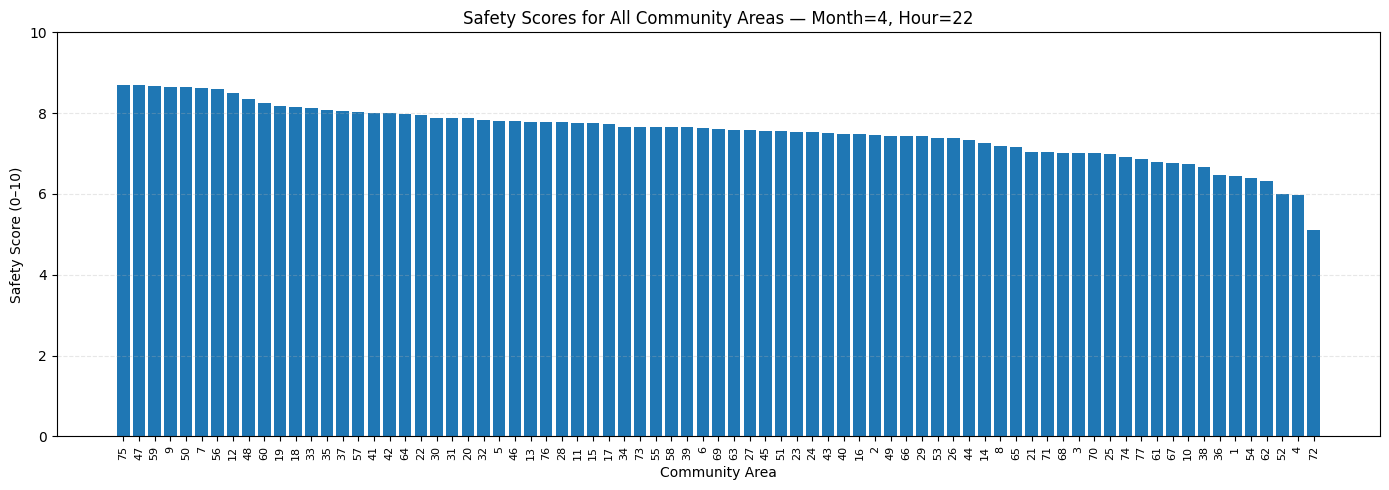

,Community_Area,Season,Time_Bucket,Year,Month,Hour,Quarter,Crime_Count,Crime_Count_Ratio,Lag_1,Lag_2,Lag_3,Roll_3,Roll_6,Predicted_Severity,Safety_Score_0_10
0,75,spring,night,2023,4,22,2,1.0,0.145735,11.321650,6.148929,7.284575,7.501860,7.379469,4.954398,8.703587
1,47,spring,night,2023,4,22,2,1.0,0.544930,5.035000,7.827500,11.562500,5.965833,6.588333,4.966431,8.699921
2,59,spring,night,2023,4,22,2,1.0,0.290763,10.135660,8.770000,6.602500,7.980220,8.197964,5.086354,8.663377
3,9,spring,night,2023,4,22,2,1.0,0.602784,14.033300,10.144600,12.505000,9.737633,10.129883,5.099085,8.659498
4,50,spring,night,2023,4,22,2,4.0,1.004106,10.620000,7.447100,6.896667,7.700700,7.971944,5.133089,8.649136
5,7,spring,night,2023,4,22,2,5.0,0.370245,5.817500,8.719050,8.535133,6.523850,6.736034,5.230100,8.619575
6,56,spring,night,2023,4,22,2,5.0,0.764205,9.534150,5.967660,7.767320,6.949937,7.078468,5.329215,8.589372
7,12,spring,night,2023,4,22,2,3.0,1.296475,6.600000,0.700000,8.034433,4.285556,5.662128,5.606559,8.504859
8,48,spring,night,2023,4,22,2,10.0,2.033436,5.035000,9.541475,6.280000,6.921132,6.904481,6.093682,8.356421
9,60,spring,night,2023,4,22,2,2.0,0.375294,6.544043,6.807217,7.289162,6.586953,7.258106,6.418960,8.257302


In [27]:
# 9) Predict safety for all areas and plot
def predict_safety_all_areas(month, hour, use_baseline_crime_count=True):
    rows = []
    for area in COMMUNITY_AREAS:
        base = area_baselines[area]
        row = {
            'Community_Area': area,
            'Season': get_season(month),
            'Time_Bucket': time_bucket(hour),
            'Year': TRAIN_YEAR_CUTOFF,
            'Month': int(month),
            'Hour': int(hour),
            'Quarter': ((int(month)-1)//3)+1,
            'Crime_Count': base['Crime_Count'] if use_baseline_crime_count else 0,
            'Crime_Count_Ratio': base['Crime_Count_Ratio'],
            'Lag_1': base['Lag_1'],
            'Lag_2': base['Lag_2'],
            'Lag_3': base['Lag_3'],
            'Roll_3': base['Roll_3'],
            'Roll_6': base['Roll_6']
        }
        rows.append(row)
    df_rows = pd.DataFrame(rows)
    preds = model.predict(df_rows[cat_cols + num_cols])
    df_rows['Predicted_Severity'] = preds
    df_rows['Safety_Score_0_10'] = df_rows['Predicted_Severity'].apply(severity_to_safety)
    return df_rows.sort_values('Safety_Score_0_10', ascending=False).reset_index(drop=True)

def plot_safety_for_month_hour(month, hour, figsize=(14,5)):
    df_safety = predict_safety_all_areas(month, hour)
    plt.figure(figsize=figsize)
    plt.bar(df_safety['Community_Area'].astype(int).astype(str), df_safety['Safety_Score_0_10'])
    plt.xlabel('Community Area')
    plt.ylabel('Safety Score (0–10)')
    plt.title(f'Safety Scores for All Community Areas — Month={month}, Hour={hour}')
    plt.xticks(rotation=90, fontsize=8)
    plt.ylim(0, 10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    return df_safety

# Example usage
month = 4
hour = 22
df_safety = plot_safety_for_month_hour(month, hour)
display(df_safety.head(30))


In [28]:
import joblib

bundle = {
    "model": model,     # your entire pipeline including preprocess
    "feature_columns": X_train.columns.tolist()  # good practice
}

joblib.dump(bundle, "safety_model_bundle.pkl")
print("Saved safety_model_bundle.pkl")


Saved safety_model_bundle.pkl
